<a href="https://colab.research.google.com/github/hamednasr/missing-data-with-pytorch/blob/main/finding_missing_data_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1864]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from IPython import display
display.set_matplotlib_formats('svg')

In [1865]:
url  = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [1866]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [1867]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


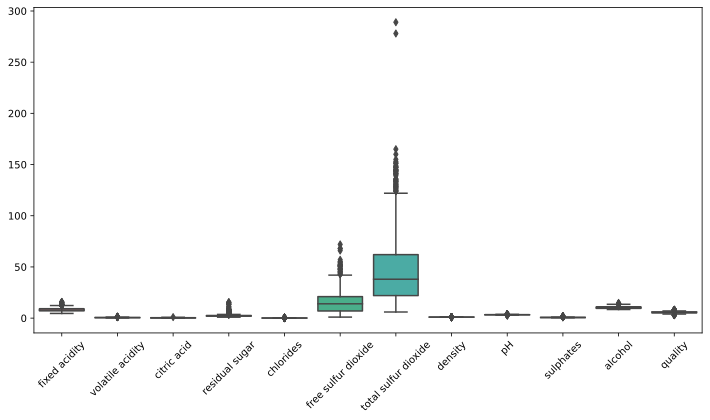

In [1868]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data)
plt.xticks(rotation=45);

In [1869]:
data[data['total sulfur dioxide']>150]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
109,8.1,0.785,0.52,2.0,0.122,37.0,153.0,0.99690,3.21,0.69,9.3,5
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,6
515,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3,5
651,9.8,0.880,0.25,2.5,0.104,35.0,155.0,1.00100,3.41,0.67,11.2,5
672,9.8,1.240,0.34,2.0,0.079,32.0,151.0,0.99800,3.15,0.53,9.5,5
684,9.8,0.980,0.32,2.3,0.078,35.0,152.0,0.99800,3.25,0.48,9.4,5
1079,7.9,0.300,0.68,8.3,0.050,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.300,0.68,8.3,0.050,37.5,289.0,0.99316,3.01,0.51,12.3,7
1244,5.9,0.290,0.25,13.4,0.067,72.0,160.0,0.99721,3.33,0.54,10.3,6


In [1870]:
data[data['total sulfur dioxide']>150].index

Int64Index([109, 354, 515, 651, 672, 684, 1079, 1081, 1244], dtype='int64')

In [1871]:
data.drop(labels = data[data['total sulfur dioxide']>150].index,axis=0,inplace=True)

In [1872]:
data[data['total sulfur dioxide']>150]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


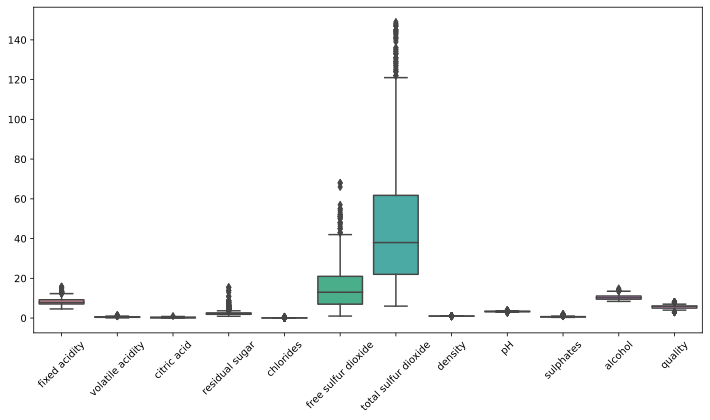

In [1873]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data)
plt.xticks(rotation=45);

### normalize data and train test sets:

In [1874]:
data = pd.DataFrame(stats.zscore(data,axis=0),columns=data.columns)
data.drop(columns='quality',inplace=True)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528229,0.973558,-1.388146,-0.456045,-0.243900,-0.460450,-0.376529,0.561093,1.285458,-0.580729,-0.960326
1,-0.298643,1.988039,-1.388146,0.055498,0.222793,0.900088,0.686333,0.028057,-0.723681,0.128093,-0.584435
2,-0.298643,1.311718,-1.182524,-0.163735,0.095513,-0.071725,0.267630,0.134664,-0.334816,-0.049112,-0.584435
3,1.652842,-1.393564,1.490569,-0.456045,-0.265113,0.122638,0.460877,0.667701,-0.982925,-0.462592,-0.584435
4,-0.528229,0.973558,-1.388146,-0.456045,-0.243900,-0.460450,-0.376529,0.561093,1.285458,-0.580729,-0.960326
...,...,...,...,...,...,...,...,...,...,...,...
1585,-1.216989,0.409957,-0.976901,-0.382968,0.053087,1.580358,-0.054450,-0.984713,0.896592,-0.462592,0.073376
1586,-1.389179,0.128157,-0.874090,-0.236813,-0.540887,2.260627,0.171006,-0.867445,1.350269,0.600641,0.731186
1587,-1.159592,-0.097283,-0.719873,-0.163735,-0.243900,1.288814,-0.183281,-0.536962,0.702159,0.541573,0.543240
1588,-1.389179,0.663578,-0.771279,-0.382968,-0.265113,1.580358,-0.054450,-0.680882,1.674323,0.305299,-0.208543


In [1875]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03,1.590000e+03
mean,-9.830012e-16,3.826429e-17,-2.633812e-16,4.908722e-17,4.253062e-16,-1.274313e-18,-2.147129e-18,-1.714010e-14,2.908575e-15,9.965299e-16,-1.713025e-15
std,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00,1.000315e+00
min,-2.135335e+00,-2.295325e+00,-1.388146e+00,-1.186820e+00,-1.601553e+00,-1.432263e+00,-1.278351e+00,-3.559281e+00,-3.704985e+00,-1.939304e+00,-1.900055e+00
25%,-7.004192e-01,-7.736037e-01,-9.254954e-01,-4.560451e-01,-3.711800e-01,-8.491752e-01,-7.630239e-01,-6.115875e-01,-6.588705e-01,-6.397971e-01,-8.663532e-01
50%,-2.412463e-01,-4.092307e-02,-5.159962e-02,-2.368125e-01,-1.802600e-01,-2.660873e-01,-2.476972e-01,-1.260514e-03,-1.076106e-02,-2.263177e-01,-2.085430e-01
75%,5.049097e-01,6.283525e-01,7.708905e-01,5.549755e-02,5.308670e-02,5.113632e-01,5.172410e-01,5.757517e-01,5.725374e-01,4.234356e-01,6.372130e-01
max,4.350483e+00,5.933242e+00,3.752417e+00,9.482498e+00,1.110523e+01,5.078885e+00,3.327382e+00,3.700679e+00,4.526005e+00,7.925132e+00,4.208183e+00


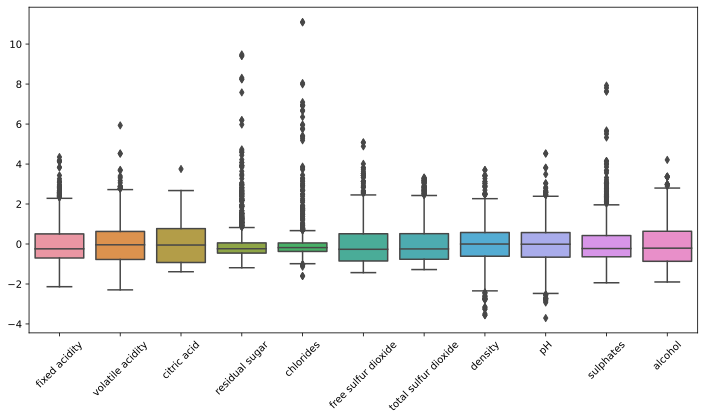

In [1876]:
plt.figure(figsize=(12,6))
sns.boxplot(data = data)
plt.xticks(rotation=45);

In [1877]:
dataT = torch.FloatTensor(data.values)

In [1878]:
testIndex=np.random.choice(range(1599),size = 10,replace=False)

In [1879]:
trainIndex=list(set(data.index)-set(testIndex))

In [1880]:
list(range(3))+list(range(4,12))

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11]

In [1881]:
#eliminating quality column,
train_data = torch.hstack([dataT[trainIndex,:3],dataT[trainIndex,4:]])
train_labels = dataT[trainIndex,3]
train_labels = train_labels[:,None]
test_data = torch.hstack([dataT[testIndex,:3],dataT[testIndex,4:]])
test_labels = dataT[testIndex,3]
test_labels = test_labels[:,None]

In [1882]:
test_data.shape

torch.Size([10, 10])

In [1883]:
train_sets = TensorDataset(train_data,train_labels)
test_sets = TensorDataset(test_data,test_labels)

batchsize = 32
train_loader = DataLoader(train_sets, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_sets, batch_size=test_sets.tensors[0].shape[0])

# creat model

In [1884]:
def CreatModel():

  ANNreg = nn.Sequential(
              nn.Linear(10,128),
              nn.ReLU(),
              nn.Linear(128,128),
              nn.ReLU(),
              nn.Linear(128,1) 
                        )

  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(params=ANNreg.parameters(), lr=0.001)

  return ANNreg, lossfun, optimizer

## test the created model:

In [1885]:
ANNreg, lossfun, optimizer = CreatModel()
d = torch.randn(5,10)
l = torch.randn(5,1)
print('data is: \n', d)
print('label is: \n', l)
print(l.shape)
yhat = ANNreg(d)
print('yhat is: ',yhat)
print('MSEloss: ',nn.MSELoss()(yhat,l).detach())

print('corrcoef: ',np.corrcoef(l.T,yhat.detach().T)[0,1])

data is: 
 tensor([[-2.0284, -2.4674, -0.4188, -2.1729, -1.3842, -2.4242,  0.1056,  0.4578,
          1.2620, -1.2561],
        [-0.4201, -0.2161, -0.2503, -0.4706,  0.8430,  0.2294,  0.6981, -0.0208,
         -0.2538,  0.8883],
        [ 1.3960,  1.3127,  1.2352,  0.3706,  2.8737,  0.1099, -0.2208, -0.3004,
          1.4231, -0.6373],
        [-0.8769,  1.6472, -0.5454,  0.2171,  0.9469,  0.4462, -0.3468,  0.0682,
          0.1007,  2.2963],
        [-1.0899, -2.1474, -0.7125, -0.8662, -0.1448,  1.2322,  1.2452,  1.0864,
          0.5353,  0.1861]])
label is: 
 tensor([[-1.5015],
        [-0.1896],
        [-0.7264],
        [ 0.7913],
        [ 0.4862]])
torch.Size([5, 1])
yhat is:  tensor([[-0.1587],
        [-0.1041],
        [-0.2401],
        [-0.0503],
        [-0.0964]], grad_fn=<AddmmBackward0>)
MSEloss:  tensor(0.6189)
corrcoef:  0.735816253824568


# Train Model

In [1886]:
epochs = 150
def TrainModel():

  ANNreg, lossfun, optimizer = CreatModel()
  losses = []

  for i in range(epochs):

    batchLoss = []

    for X,y in train_loader:
      
      yhat = ANNreg(X)

      
      loss = lossfun(yhat,y)

      batchLoss.append(loss.detach().item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
    losses.append(np.mean(batchLoss))


  return ANNreg, losses 


In [1892]:
ANNreg, losses  = TrainModel()

In [1893]:
trainpred = ANNreg(train_data)
trainR = np.corrcoef(trainpred.detach().T,train_labels.T)[0,1]

In [1894]:
testpred = ANNreg(test_data)
testR = np.corrcoef(testpred.detach().T,test_labels.T)[0,1]

In [1895]:
print(testpred.T)
test_labels.T

tensor([[ 2.2255,  5.1102, -0.2601, -0.1589,  0.0603, -0.7147, -0.4518,  0.1190,
         -0.5550, -0.5903]], grad_fn=<PermuteBackward0>)


tensor([[ 2.7594,  3.0517, -0.2368, -0.2368,  0.0555, -0.4560, -0.3830, -0.0176,
         -0.3099, -0.7484]])

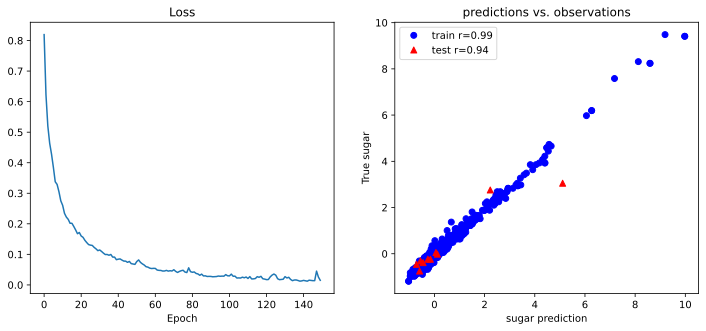

In [1896]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')

ax[1].plot(trainpred.detach(),train_labels,'bo',label=f'train r={trainR:.2f}')
ax[1].plot(testpred.detach(),test_labels,'r^',label=f'test r={testR:.2f}')
ax[1].set_xlabel('sugar prediction')
ax[1].set_ylabel('True sugar')
ax[1].set_title('predictions vs. observations')
ax[1].legend()

plt.show()